In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Flatten
from tensorflow.keras.models import Model
import time

# Heston model

In [3]:
def simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0):
    dt = T / N
    prices = np.zeros(N)
    variance = np.zeros(N)

    prices[0] = S0
    variance[0] = v0

    for t in range(1, N):
        wt = np.random.normal(0, np.sqrt(dt))
        wv = rho * wt + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt))

        variance[t] = np.abs(variance[t - 1] + kappa * (theta - variance[t - 1]) * dt + sigma * np.sqrt(variance[t - 1]) * wv)
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * variance[t]) * dt + np.sqrt(variance[t]) * wt)

    return prices, variance

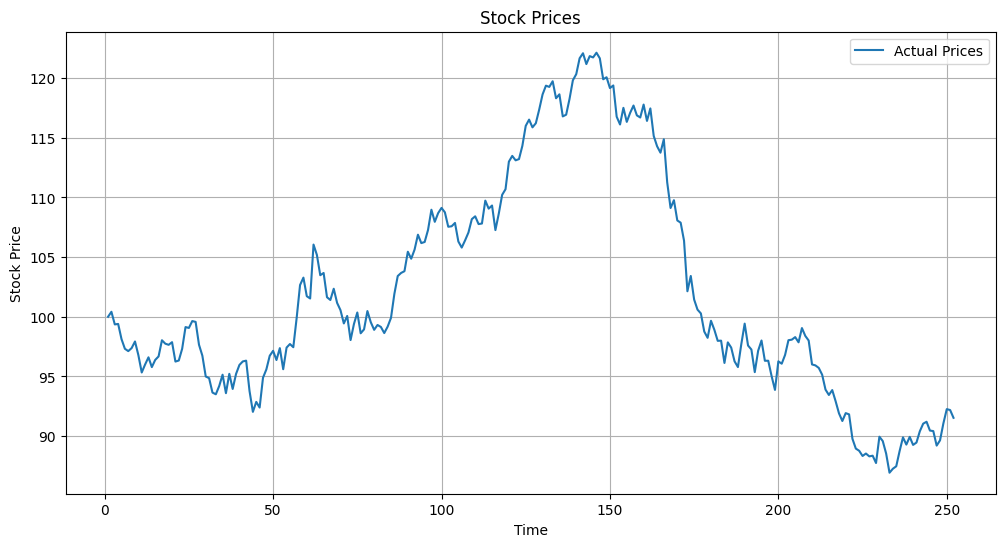

In [5]:
mu = 0.05
kappa = 1.5
theta = 0.04
sigma = 0.3
rho = -0.6
T = 1.0
N = 252
S0 = 100
v0 = 0.04
time_ = list(range(1, N+1))
stock_prices, variances = simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0)
plt.figure(figsize=(12, 6))
plt.plot(time_,  stock_prices, label='Actual Prices')
plt.title('Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
log_stock_prices = np.log(stock_prices)

## Neural Network to Fitting data with MLP

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test loss: 123.12853240966797
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


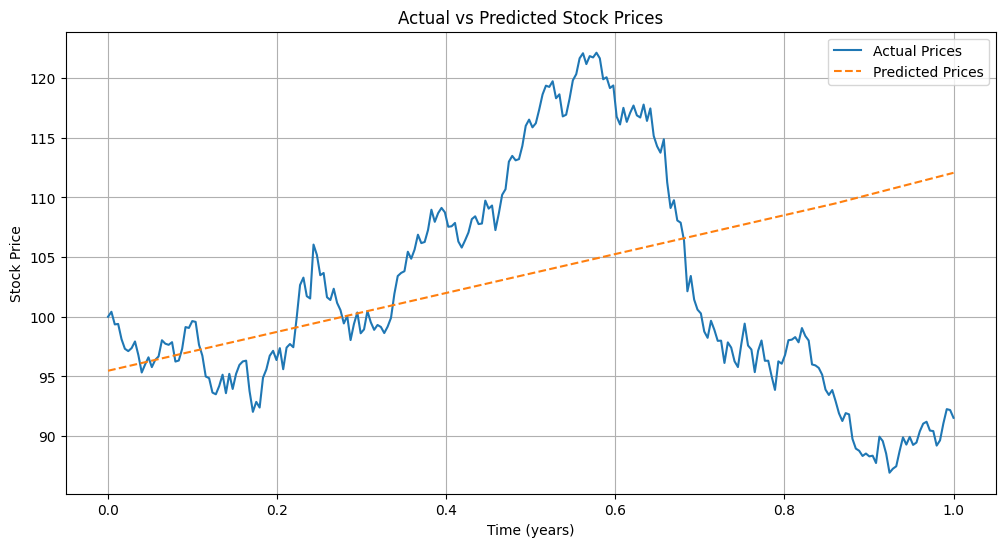

In [7]:
time_steps = np.linspace(0, T, N).reshape(-1, 1)


model = Sequential([
    Dense(128, activation='relu', input_shape=(1,)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(time_steps, stock_prices, epochs=100, batch_size=16, validation_split=0.2, verbose=0)

# Evaluate the model
loss = model.evaluate(time_steps, stock_prices, verbose=0)
print(f"Test loss: {loss}")

# Predictions
predictions = model.predict(time_steps)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_steps,  stock_prices, label='Actual Prices')
plt.plot(time_steps, predictions, label='Predicted Prices', linestyle='dashed')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Neural Network to Fitting data with LSTM, Attention in MLP

In [8]:
input_shape = (1, time_steps.shape[1])
inputs = Input(shape=input_shape)

lstm_out = LSTM(128, return_sequences=True)(inputs)
query = lstm_out
value = lstm_out
attention_output = Attention()([query, value])
flattened_output = Flatten()(attention_output)
dense1 = Dense(64, activation='relu')(flattened_output)
dropout = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout)
final_output = Dense(1)(dense2)


model = Model(inputs=inputs, outputs=final_output)
model.compile(optimizer='adam', loss='mean_squared_error')


time_steps_3D = time_steps.reshape((time_steps.shape[0], 1, time_steps.shape[1]))


history = model.fit(time_steps_3D, stock_prices, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

loss = model.evaluate(time_steps_3D, stock_prices, verbose=0)
print(f"Test loss: {loss}")

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 10931.0840 - val_loss: 8427.4580
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10922.2227 - val_loss: 8401.5420
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10955.6221 - val_loss: 8362.6309
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11099.7461 - val_loss: 8304.0566
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10928.9297 - val_loss: 8215.2109
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10737.0303 - val_loss: 8079.8789
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10649.4111 - val_loss: 7876.6562
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 10455.3486 - val_loss: 7579.9404
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10224.9375 - val_loss: 7158.2661
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9936.2705 - val_loss: 6580.3765
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9311.4990 - val_loss: 5818.8516
Epoch 12/20

1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


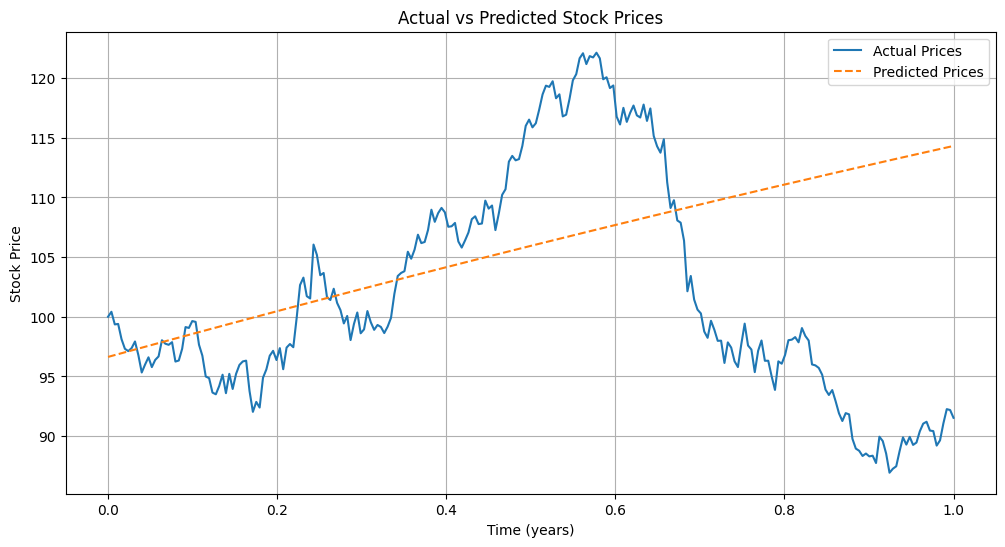

In [9]:
predictions_lstm = model.predict(time_steps)
plt.figure(figsize=(12, 6))
plt.plot(time_steps,  stock_prices, label='Actual Prices')
plt.plot(time_steps, predictions_lstm, label='Predicted Prices', linestyle='dashed')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def estimate_extended_kalman_heston(log_stock_prices, N, muS, omega, theta, xi, rho):
    n_stock_prices = len(log_stock_prices)
    delt = 1.0 / N
    eps = 0.00001
    x = 0.04
    P = 0.01

    u = np.zeros(n_stock_prices)
    v = np.ones(n_stock_prices)
    estimates = np.zeros(n_stock_prices)
    u[0] = u[-1] = 0.0
    v[0] = v[-1] = 1.0
    estimates[0] = estimates[1] = log_stock_prices[0] + eps
    likelihood = 0

    for i1 in range(1, n_stock_prices - 1):
        if x < 0:
            x = 0.00001


        x1 = x + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1 - 1])
        x1 = np.clip(x1, -1e6, 1e6)
        A = 1.0 - (theta - 0.5 * rho * xi) * delt
        rho = np.clip(rho, -1, 1)
        W = xi * np.sqrt((1 - rho ** 2) * x * delt)
        P1 = W ** 2 + A * P * A

        if x1 < 0:
            x1 = 0.00001

        H = -0.5 * delt
        U = np.sqrt(x1 * delt)
        K = P1 * H / (H * P1 * H + U ** 2)
        z = log_stock_prices[i1 + 1]
        x_update = x1 + K * (z - (log_stock_prices[i1] + (muS - 0.5 * x1) * delt))
        x = np.clip(x_update, -1e6, 1e6)

        u[i1] = z - (log_stock_prices[i1] + (muS - 0.5 * x1) * delt)
        v[i1] = H * P1 * H + U ** 2

        likelihood_term = np.log(v[i1]) + np.log(u[i1]**2) / v[i1]
        likelihood += np.clip(likelihood_term, -1e6, 1e6)

        estimates[i1 + 1] = log_stock_prices[i1] + (muS - 0.5 * x1) * delt
        P = (1.0 - K * H) * P1

    return u, v, estimates, likelihood

In [11]:
u, v, estimates, likelihood = estimate_extended_kalman_heston(log_stock_prices, N, mu, kappa, theta, sigma, rho)
def negative_log_likelihood(params):
    mu, kappa, theta, sigma, rho = params
    u, v, estimates, like = estimate_extended_kalman_heston(log_stock_prices, N, mu, kappa, theta, sigma, rho)
    likelihood = sum(np.log(v[i]) + (u[i]**2) / v[i] for i in range(len(u)))
    if np.isscalar(likelihood):
        return -likelihood
    else:
        return -np.sum(likelihood)

In [12]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

np.float64(1.1828004737042135)

In [13]:
result = minimize(negative_log_likelihood, x0=[mu, kappa, theta, sigma, rho],bounds =[[0,1], [1,2], [0, 0.5],[0, 0.5], [-1, 0]] , method="L-BFGS-B",tol=1e-12)


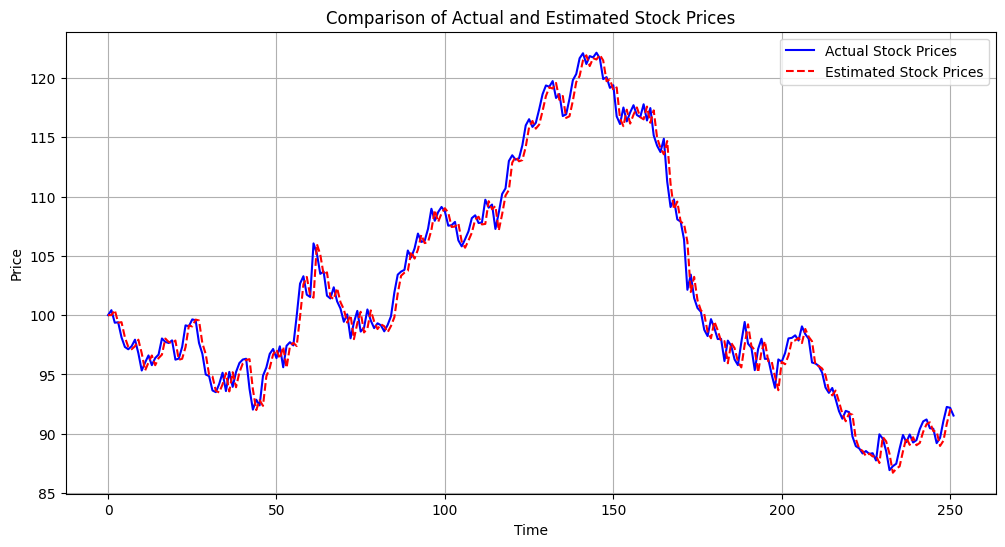

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()